In [598]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import numpy as np
import pandas as pd
from multirotor.coords import body_to_inertial, direction_cosine_matrix, inertial_to_body

In [599]:
def apply_forces_torques(
    forces: np.ndarray, torques: np.ndarray, x: np.ndarray, g: float, mass: float,
    inertia_matrix: np.matrix, inertia_matrix_inverse: np.matrix
) -> np.ndarray:
    """
    Given forces and torqes, return the rate of change of state.

    Parameters
    ----------
    forces : np.ndarray
        Forces acting in the body frame.
    torques : np.ndarray
        Torques acting in the body frame.
    x : np.ndarray
        State of the vehicle.
    g : float
        Gravitational acceleration.
    mass : float
        Mass of the vehicle.
    inertia_matrix : np.matrix
        Inertial matrix.
    inertia_matrix_inverse : np.matrix
        Inverse of inertial matrix.

    Returns
    -------
    np.ndarray
        The rate of change of state d(state)/dt
    """
    # dcm = direction_cosine_matrix(x[6], x[7], x[8])
    # dcm = dcm.astype(np.float32)
    # forces = forces.astype(np.float32)
    # forces[2] = body_to_inertial(forces, dcm)
    # dcm = direction_cosine_matrix(x[6], x[7], x[8])
    # dcm = dcm.astype(np.float32)
    # x[3:6] = inertial_to_body(np.array(x[3:6], dtype=np.float32), dcm)
    # Store state variables in a readable format
    xI = x[0]       # Inertial frame positions
    yI = x[1]
    zI = x[2]
    ub = x[3]       # linear velocity along body-frame-x-axis b1
    vb = x[4]       # linear velocity along body-frame-y-axis b2
    wb = x[5]       # linear velocity along body-frame-z-axis b3
    phi = x[6]      # Roll
    theta = x[7]    # Pitch
    psi = x[8]      # Yaw
    p = x[9]        # body-frame-x-axis rotation rate
    q = x[10]       # body-frame-y-axis rotation rate
    r = x[11]       # body-frame-z-axis rotation rate
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)    # roll
    cthe = np.cos(theta); sthe = np.sin(theta)  # pitch
    cpsi = np.cos(psi);   spsi = np.sin(psi)    # yaw

    f1, f2, f3 = forces # in the body frame (b1, b2, b3)
    t1, t2, t3 = torques
    I = inertia_matrix
    I_inv = inertia_matrix_inverse
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros_like(x)

    # velocity = dPosition (inertial) / dt (convert body velocity to inertial)
    # Essentially = Rotation matrix (body to inertial) x body velocity
    # dcm = direction_cosine_matrix(roll=phi, pitch=theta, yaw=psi)
    # xdot[0:3] = body_to_inertial(x[3:6], dcm)
    xdot[0] = cthe*cpsi*ub + (-cphi * spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xIdot 
    xdot[1] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yIdot 
    xdot[2] = (-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = zIdot

    #  Acceleration = dVelocity (body frame) / dt
    #           External forces     Gravity             Coriolis effect
    xdot[3] = 1/mass * (f1)     + g * sthe           + r * vb - q * wb  # = udot
    xdot[4] = 1/mass * (f2)     - g * sphi * cthe    - r * ub + p * wb # = vdot
    xdot[5] = 1/mass * (f3)     - g * cphi * cthe    + q * ub - p * vb # = wdot

    # Orientation
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot

    # Angular rate
    gyro = np.cross(x[9:12], I @ x[9:12])
    xdot[9:12] = I_inv @ (torques - gyro)
    
    return xdot


def dxdt_speeds(t: float, x: np.ndarray, forces:np.ndarray, torques:np.ndarray, params=None
    ):
        """
        Calculate the rate of change of state given the propeller speeds on the
        system (rad/s).

        Parameters
        ----------
        t : float
            Time. Currently this function is time invariant.
        x : np.ndarray
            State of the vehicle.
        u : np.ndarray
            A p-vector of propeller speeds (rad/s), where p=number of propellers.
        disturb_forces : np.ndarray, optional
            Disturbinng x,y,z forces in the vehicle's local frame, by default 0.
        disturb_torques : np.ndarray, optional
            Disturbing x,y,z torques in the vehicle's local frame, by default 0.

        Returns
        -------
        np.ndarray
            The rate of change of state.
        """
        inertia_matrix=np.asarray([
            [0.2506, 0, 0],
            [0, 0.2506, 0.],
            [0, 0, 0.4538]
        ])
        # print('dxdt-x', self.t // self.simulation.dt, x.dtype)
        # g = 9.8
        g = 0
        dxdt = apply_forces_torques(forces, torques, x, g, 10.66, inertia_matrix, np.linalg.inv(inertia_matrix))
        # print('dxdt', self.t // self.simulation.dt, dxdt.dtype)
        return dxdt

def get_forces_torques_matlab(speeds: np.ndarray, state: np.ndarray):
        """
        Calculate the forces and torques acting on the vehicle's center of gravity
        given its current state and speed of propellers.

        Parameters
        ----------
        speeds : np.ndarray
            Propeller speeds (rad/s)
        state : np.ndarray
            State of the vehicle (position, velocity, orientation, angular rate)

        Returns
        -------
        Tuple[np.ndarray, np.ndarray]
            The forces and torques acting on the body.
        """
        l = 0.635
        
        b=9.8419e-05
        T = b*(speeds**2)

        T_total=np.sum(T)


        #### Start new block

        Phi = state[6]
        The = state[7]
        Psi = state[8]

        g=9.80
        m_t=10.66
        l=0.635

        R_b_e = np.array([[np.cos(Psi)*np.cos(The), np.cos(Psi)*np.sin(The)*np.sin(Phi)-np.sin(Psi)*np.cos(Phi), np.cos(Psi)*np.sin(The)*np.cos(Phi)+np.sin(Psi)*np.sin(Phi)],
                  [np.sin(Psi)*np.cos(The), np.sin(Psi)*np.sin(The)*np.sin(Phi)+np.cos(Psi)*np.cos(Phi), np.sin(Psi)*np.sin(The)*np.cos(Phi)-np.cos(Psi)*np.sin(Phi)],
                  [-np.sin(The), np.cos(The)*np.sin(Phi), np.cos(The)*np.cos(Phi)]])

        # Computing Ftot_b
        # Ftot_b = np.dot(R_b_e.T, np.array([[0], [0], [-m_t*g]])) + np.array([[0], [0], [T_total]])
        Ftot_b = R_b_e.T @ np.array([[0], [0], [-m_t*g]]) + np.array([[0], [0], [T_total]])

        # Rounding to one decimal place
        Ftot_b = np.round(Ftot_b*10) / 10

        # Extracting components Fx, Fy, Fz
        Fx, Fy, Fz = Ftot_b.flatten()


        ### end new block
        
        # Ftot_b=[0, 0, T_total]
        # Fx=Ftot_b[0]
        # Fy=Ftot_b[1]
        # Fz=Ftot_b[2]

        d=1.8503e-06; 
        M = d*(speeds**2)
        
        angsm=np.cos(np.pi/8) 
        anglg=np.cos(3*np.pi/8)

        Mx=l*(-T[0]*anglg -T[1]*angsm +T[2]*angsm +T[3]*anglg +T[4]*anglg+T[5]*angsm -T[6]*angsm -T[7]*anglg)

        My=l*(-T[0]*angsm -T[1]*anglg -T[2]*anglg -T[3]*angsm +T[4]*angsm+T[5]*anglg +T[6]*anglg +T[7]*angsm)

        Mz= M[0] -M[1] +M[2] -M[3] +M[4] -M[5] +M[6] -M[7]

        Mx = np.round(Mx*10) / 10
        My = np.round(My*10) / 10
        Mz = np.round(Mz*10) / 10
        return np.array([Fx, Fy, Fz], dtype=np.float32).squeeze(), np.array([Mx, My, Mz], dtype=np.float32)

def allocate_control_matlab(thrust: float, torques: np.ndarray) -> np.ndarray:
        """
        Allocate control to propellers by converting prescribed forces and torqes
        into propeller speeds. Uses the control allocation matrix.

        Parameters
        ----------
        thrust : float
            The thrust in the body z-direction.
        torques : np.ndarray
            The roll, pitch, yaw torques required about (x, y, z) axes.

        Returns
        -------
        np.ndarray
            The prescribed propeller speeds (rad /s)
        """
        l=0.635
        b=9.8419e-05
        d=1.8503e-06

        angsm = np.cos(np.pi/8)
        anglg = np.cos(3*np.pi/8)
        
        A_f = np.array([[b, b, b, b, b, b, b, b],
                       [-b*l*anglg, -b*l*angsm, b*l*angsm, b*l*anglg, b*l*anglg, b*l*angsm, -b*l*angsm, -b*l*anglg],
                       [-b*l*angsm, -b*l*anglg, -b*l*anglg, -b*l*angsm, b*l*angsm, b*l*anglg, b*l*anglg, b*l*angsm],
                       [d, -d, d, -d, d, -d, d, -d]], dtype=np.float32)
        
        u_des = np.array([thrust, torques[0], torques[1], torques[2]], dtype=np.float32)
        
        a = np.linalg.pinv(A_f)
        Omega_s = np.linalg.pinv(A_f) @ np.expand_dims(u_des, 1)
        
        wref = np.zeros(8)
        for i in range(len(Omega_s)):
            if Omega_s[i] < 0:
                wref[i] = 0
            elif Omega_s[i] > 670**2:
                wref[i] = 670
            else:
                wref[i] = np.sqrt(Omega_s[i])
        
        return np.round(wref, 1)

In [600]:
# def simulate(alloc_in, initial_state):
#     force = alloc_in[:,0]
#     torques = alloc_in[:,1:4]
#     log = []
#     fs = []
#     ts = []

#     state = initial_state
#     dcm = direction_cosine_matrix(state[6], state[7], state[8])
#     dcm = dcm.astype(np.float32)
#     state[3:6] = inertial_to_body(np.array(state[3:6], dtype=np.float32), dcm)

#     for f, t in zip(force, torques):

#         wref = allocate_control_matlab(f, t)
#         # wref = 0.10472 * wref
#         forces, torques = get_forces_torques_matlab(np.array(wref), np.array(state))
#         fs.append(forces)
#         ts.append(torques)
        
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         # state[3:6] = inertial_to_body(state[3:6], dcm)
        

#         state = odeint(
#             dxdt_speeds, state, (0, 0.01),
#             args=(forces, torques),
#             rtol=1e-4, atol=1e-4, tfirst=True
#         )[-1]
        
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         dcm = dcm.astype(np.float32)
#         state_copy = np.array(state, dtype=np.float32)
#         state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

#         log.append(state_copy)

#     return np.array(log), np.array(fs), np.array(ts)

In [601]:
def simulate_first_two(speeds, initial_state):
    log = []
    fs = []
    ts = []
    state = initial_state
    # dcm = direction_cosine_matrix(state[6], state[7], state[8])
    # dcm = dcm.astype(np.float32)
    # state[3:6] = inertial_to_body(np.array(state[3:6], dtype=np.float32), dcm)
    speeds = speeds * (2 * np.pi / 60)
    for w in speeds:
        # dcm = direction_cosine_matrix(state[6], state[7], state[8])
        # dcm = dcm.astype(np.float32)
        # state[3:6] = inertial_to_body(np.array(state[3:6], dtype=np.float32), dcm)

        # the forces and torques are correct from here when applying only one step
        forces, torques = get_forces_torques_matlab(np.array(w), np.array(state))
        fs.append(forces)
        ts.append(torques)
        # dcm = direction_cosine_matrix(state[6], state[7], state[8])
        # dcm = dcm.astype(np.float32)
        # forces = inertial_to_body(np.array(forces, dtype=np.float32), dcm)

        s_copy = state.copy()
        state = solve_ivp(dxdt_speeds, (0, 0.01), s_copy, args=(forces, torques), method='RK45', t_eval=np.arange(0, 0.01, 0.00001), rtol=1e-12, atol=1e-12).y[:,-1]

        dcm = direction_cosine_matrix(state[6], state[7], state[8])
        dcm = dcm.astype(np.float32)
        state_copy = np.array(state, dtype=np.float32)
        state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

        # state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

        log.append(state_copy)

    return np.array(log), np.array(fs), np.array(ts)

In [602]:
# def simulate_first_two(speeds, states):
#     log = []
#     fs = []
#     ts = []
#     speeds = speeds * (2 * np.pi / 60)

#     for w, s in zip(speeds, states):
#         dcm = direction_cosine_matrix(s[6], s[7], s[8])
#         dcm = dcm.astype(np.float32)
#         s[3:6] = inertial_to_body(np.array(s[3:6], dtype=np.float32), dcm)

#         forces, torques = get_forces_torques_matlab(np.array(w), np.array(s)) # these are correct
#         fs.append(forces)
#         ts.append(torques)

#         state = odeint( 
#             dxdt_speeds, s, (0, 0.01),
#             args=(forces, torques),
#             rtol=1e-9, atol=1e-9, tfirst=True
#         )[-1]
        
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         dcm = dcm.astype(np.float32)
#         state_copy = np.array(state, dtype=np.float32) 
#         # state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

#         log.append(state_copy)

#     return np.array(log), np.array(fs), np.array(ts)

In [603]:
scenarios = ['faulty', 'nominal']

scenario = scenarios[1]

In [604]:
# importing from matlab
# true_states = pd.read_csv(f'../data/{scenario}_states.csv', header=None)
true_states = pd.read_csv(f'../data/{scenario}_states_skip.csv', header=None)
true_states = np.array(true_states)

alloc_in = pd.read_csv(f'../data/allocation_in_skip.csv', header=None)
alloc_in = np.array(alloc_in)

true_f = pd.read_csv(f'../data/{scenario}_f_skip.csv', header=None)
true_f = np.array(true_f)

true_t = pd.read_csv(f'../data/{scenario}_m_skip.csv', header=None)
true_t = np.array(true_t)

In [605]:
motor_speeds = pd.read_csv(f'../data/{scenario}_speeds_skip.csv', header=None)
motor_speeds = np.array(motor_speeds)

In [606]:
initial_state = true_states[0]

In [607]:
# log, fs, ts = simulate(alloc_in, initial_state)
log, fs, ts = simulate_first_two(motor_speeds, initial_state)
# log, fs, ts = simulate_first_two(motor_speeds, true_states)


Text(0.5, 1.0, 'xy')

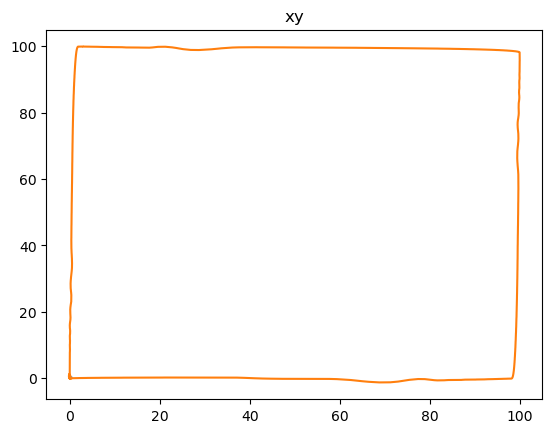

In [608]:
plt.plot(log[:,0], log[:,1])
plt.plot(true_states[:,0], true_states[:,1])
plt.title("xy")

Text(0.5, 1.0, 'z')

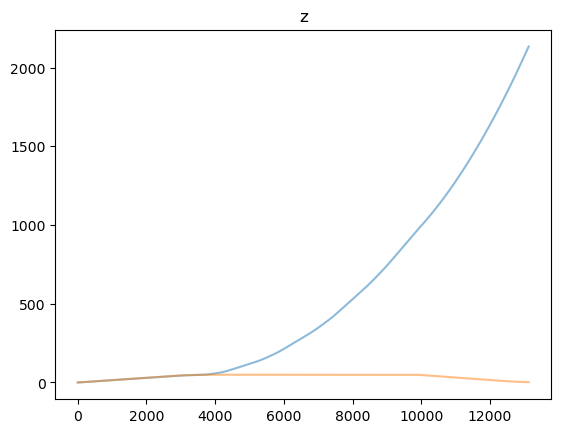

In [609]:
plt.plot(log[:,2], alpha=0.5)
plt.plot(true_states[:,2], alpha=0.5)
plt.title("z")

Text(0.5, 1.0, 'vx')

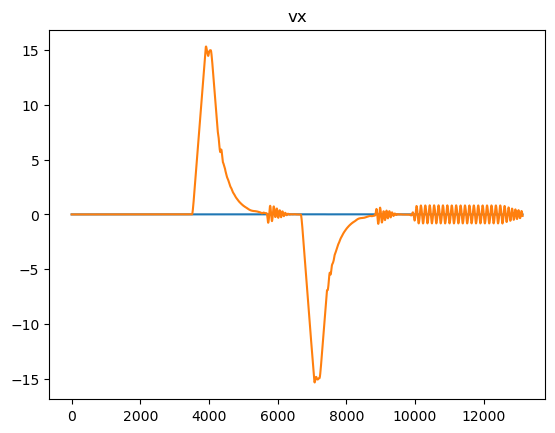

In [610]:
plt.plot(log[:,3])
plt.plot(true_states[:,3])
plt.title("vx")

Text(0.5, 1.0, 'vy')

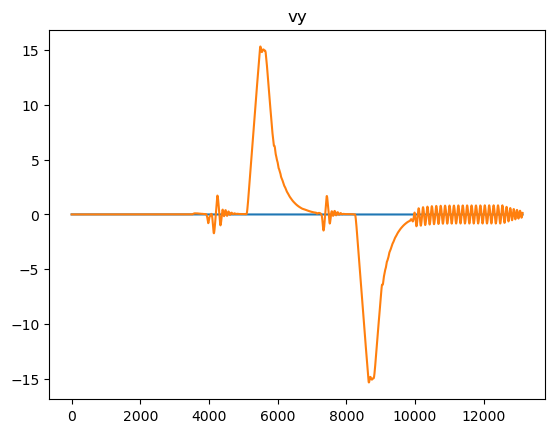

In [611]:
plt.plot(log[:,4])
plt.plot(true_states[:,4])
plt.title("vy")

Text(0.5, 1.0, 'vz')

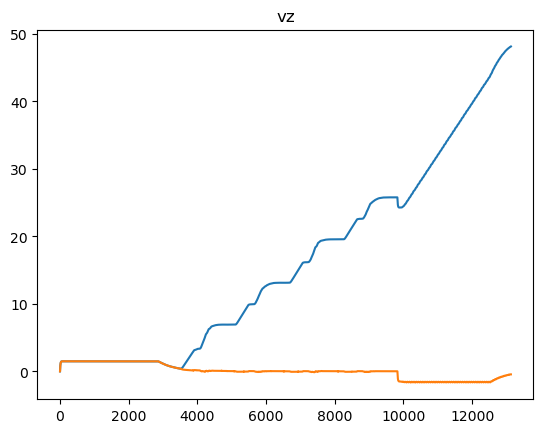

In [612]:
plt.plot(log[:,5])
plt.plot(true_states[:,5])
plt.title("vz")

Text(0.5, 1.0, 'Roll')

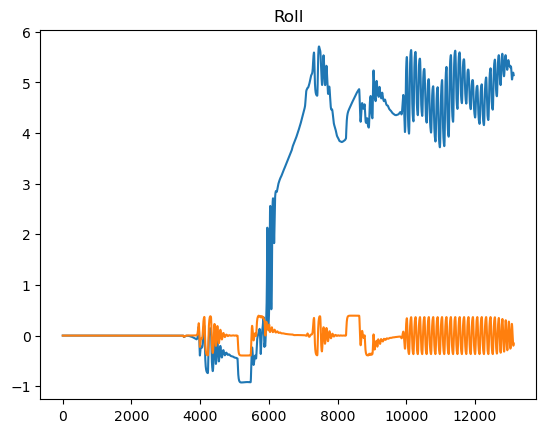

In [613]:
plt.plot(log[:,6])
plt.plot(true_states[:,6])
plt.title("Roll")

Text(0.5, 1.0, 'Pitch')

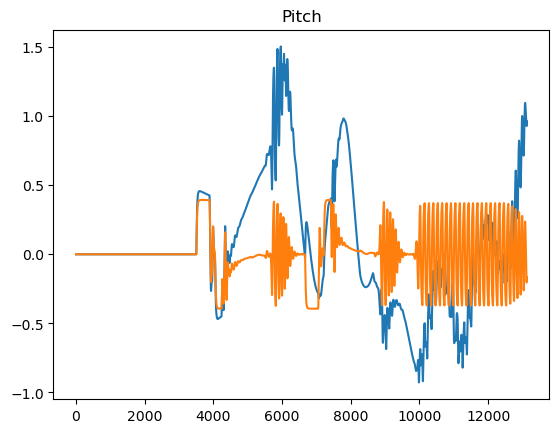

In [614]:
plt.plot(log[:,7])
plt.plot(true_states[:,7])
plt.title("Pitch")

Text(0.5, 1.0, 'Yaw')

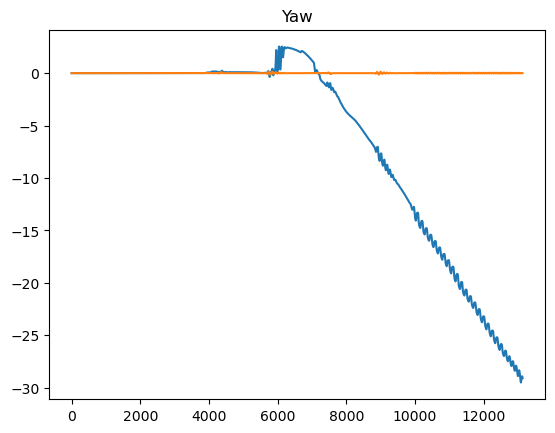

In [615]:
plt.plot(log[:,8])
plt.plot(true_states[:,8])
plt.title("Yaw")

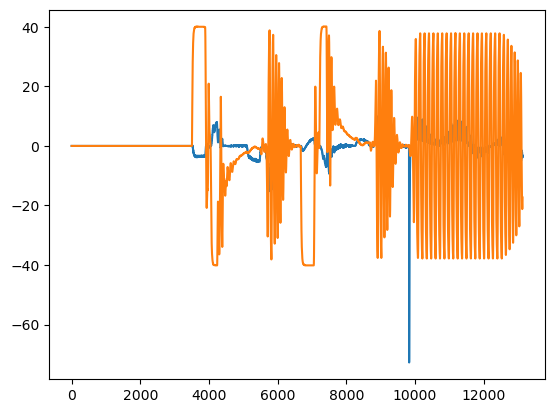

In [616]:
plt.plot(fs[:,0])
plt.plot(true_f[:,3-3])

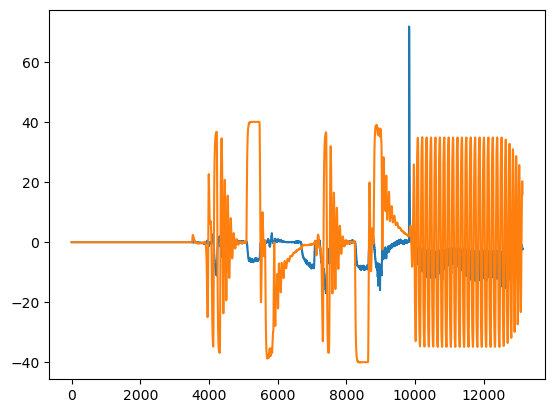

In [617]:
plt.plot(fs[:,1])
plt.plot(true_f[:,4-3])

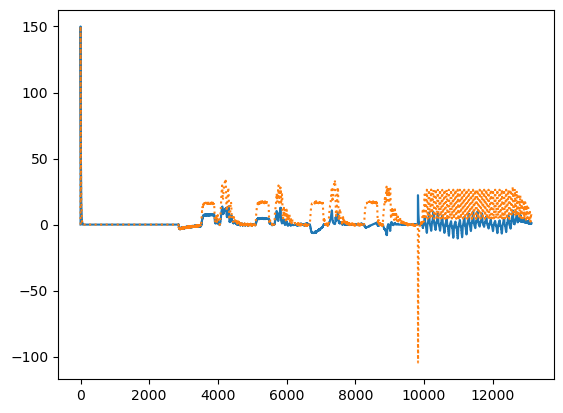

In [618]:
plt.plot(fs[:,2])
plt.plot(true_f[:,5-3], linestyle=':')

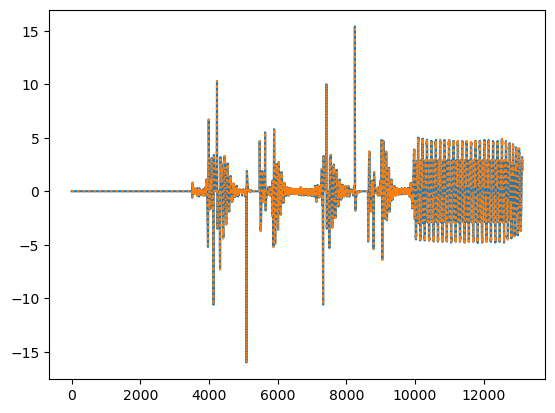

In [619]:
plt.plot(ts[:,0])
plt.plot(true_t[:,0], linestyle=':')

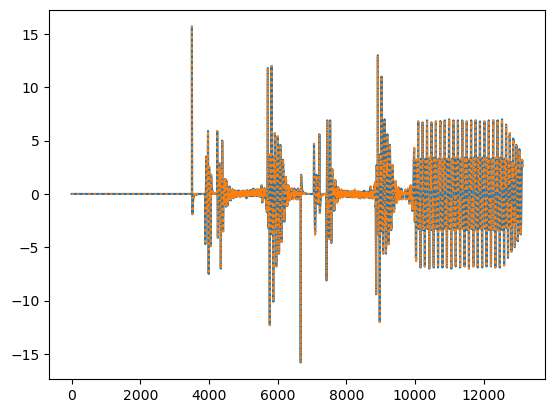

In [620]:
plt.plot(ts[:,1])
plt.plot(true_t[:,1], linestyle=':')

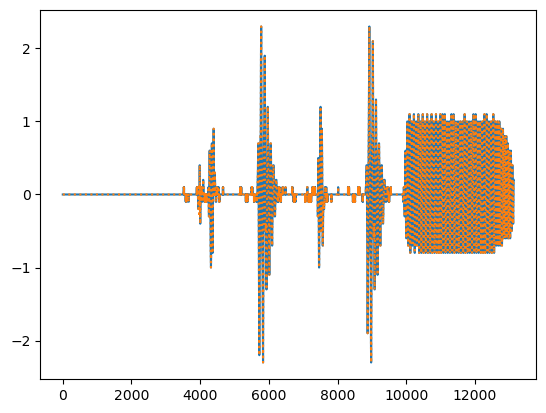

In [621]:
plt.plot(ts[:,2])
plt.plot(true_t[:,2], linestyle=':')

In [622]:
f_df = pd.DataFrame(fs)
t_df = pd.DataFrame(ts)
f_df.to_csv('../data/my_fs.csv')
t_df.to_csv('../data/my_ts.csv')

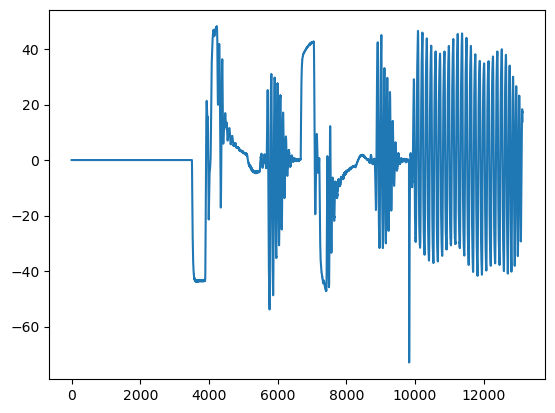

In [623]:
plt.plot(fs[:,0] - true_f[:,0])

In [624]:
fs.shape

(13129, 3)

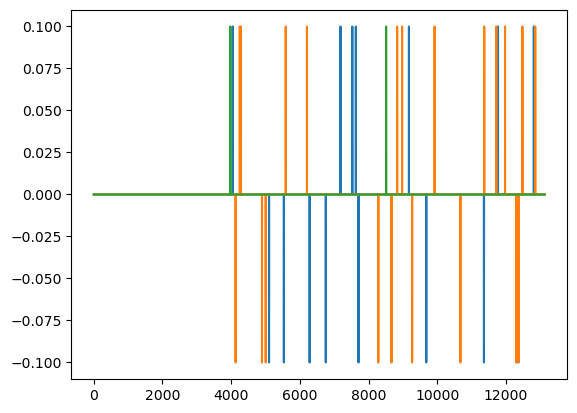

In [625]:
plt.plot(ts[:,0:3] - true_t[:,0:3])